In [ ]:
from dotenv import load_dotenv
load_dotenv()

from typing import Literal
import json
import base64
import io
import os
import re
import sys
import time
from pathlib import Path
import subprocess

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from decord import VideoReader, cpu
from PIL import Image
from tqdm.auto import tqdm

import openai
from sglang.utils import (
    execute_shell_command,
    wait_for_server,
    terminate_process,
)


def create_openai_client(base_url):
    return openai.Client(api_key="EMPTY", base_url=base_url)


def get_frames(
    p_video,
    duration_sec = 2,
    max_frames_num = 32,
):
    FPS = 30
    num_frames_segment = int(duration_sec * FPS)

    vr = VideoReader(str(p_video), ctx=cpu(0))
    total_frame_num = len(vr)
    num_segments = total_frame_num // num_frames_segment
    for segment_idx in range(num_segments):
        segment_start_idx = segment_idx * num_frames_segment
        segment_end_idx = segment_start_idx + num_frames_segment - 1
        uniform_sampled_frames = np.linspace(segment_start_idx, segment_end_idx, max_frames_num + 2, dtype=int)[1:-1]
        frame_idx = uniform_sampled_frames.tolist()
        frames = vr.get_batch(frame_idx).asnumpy()
        yield {
            'frames': frames,
            'segment_idx': segment_idx,
            'total_segments': num_segments,
            'segment_start_idx': segment_start_idx,
            'segment_end_idx': segment_end_idx,
        }


def generate_segment_caption(client: openai.Client, frames, user_prompt: str, model: str = "default"):
    base64_frames = []
    for frame in frames:
        pil_img = Image.fromarray(frame)
        buff = io.BytesIO()
        pil_img.save(buff, format="JPEG")
        base64_str = base64.b64encode(buff.getvalue()).decode("utf-8")
        base64_frames.append(base64_str)

    content = []
    if len(base64_frames) > 1:
        for base64_frame in base64_frames:
            frame_format = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_frame}"},
                "modalities": "video",
            }
            content.append(frame_format)
        content.append({
            'type': 'text',
            'text': user_prompt,
        })
    elif len(base64_frames) == 1:  # ChatGPT does not support video (actually it does, but it's traditional ML-based)
        content.append({
            'type': 'text',
            'text': user_prompt,
        })
        content.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_frames[0]}"},
        })

    messages = [{"role": "user", "content": content}]

    request = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_tokens=1024,
    )
    if request.choices[0].message.content:
        response = request.choices[0].message.content
    elif request.choices[0].message.refusal:
        response = request.choices[0].message.refusal
    return response, request


def chat(
    client: openai.Client,
    system_prompt: str,
    user_prompt: str,
    model: str = "default",
):
    messages = [
        {
            'role': 'system',
            'content': system_prompt,
        },
        {
            "role": "user",
            "content": user_prompt,
        }
    ]
    request = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_tokens=1024,
    )
    if request.choices[0].message.content:
        response = request.choices[0].message.content
    elif request.choices[0].message.refusal:
        response = request.choices[0].message.refusal
    return response

In [3]:
client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

tools = [{
    "type": "function",
    "function": {
        "name": "get_weather",
        "description": "Get current temperature for a given location.",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "City and country e.g. Bogotá, Colombia"
                }
            },
            "required": [
                "location"
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}]

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": "What is the weather like in Paris today?"}],
    tools=tools
)

print(completion.choices[0].message.tool_calls)

[ChatCompletionMessageToolCall(id='call_FA2P7M4ycyLCQskMzLMYiedv', function=Function(arguments='{"location":"Paris, France"}', name='get_weather'), type='function')]


In [ ]:
context_prompt = "The following is a scene description. If you were a law enforcement agency, how would you rate this scene on a scale from 0 to 1, with 0 representing a standard scene and 1 denoting a scene with suspicious activities?"
format_prompt = "Please provide the response in the form of a Python list and respond with only one number in the provided list below [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] without any textual explanation. It should begin with '[' and end with  ']'."
system_prompt = f'{context_prompt} {format_prompt}'
user_prompt = f"Scene Description: {response_record['response']}"

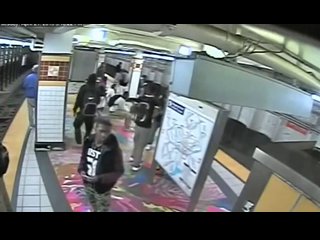

In [4]:
p_video = Path('/datasets/UCF_Crimes/Videos/Fighting/Fighting003_x264.mp4')

frame_dicts = list(get_frames(p_video, 1, 1))
Image.fromarray(frame_dicts[25]['frames'][0])

In [5]:
res, req = generate_segment_caption(client, frame_dicts[25]['frames'], "If you were a law enforcement agency, how would you rate this scene on a scale from 0 to 1, with 0 representing a standard scene and 1 denoting a scene with suspicious activities? Please provide the response in the form of a Python list and respond with only one number in the provided list below [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] without any textual explanation. It should begin with '[' and end with  ']'.", 'gpt-4o')
res, req

('[0.5]',
 ChatCompletion(id='chatcmpl-B0KxEJRH5Gl4LwgwT8BAC0hCWTSMX', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='[0.5]', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1739420248, model='gpt-4o-2024-08-06', object='chat.completion', service_tier='default', system_fingerprint='fp_4691090a87', usage=CompletionUsage(completion_tokens=6, prompt_tokens=580, total_tokens=586, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))))

In [6]:
res, req = generate_segment_caption(client, frame_dicts[25]['frames'], "Is any anomaly activity detected here in this image?", 'gpt-4o')
res, req

("I'm unable to determine specific activities or anomalies in images. If you have concerns about the image, it might be best to consult with a security professional or use specialized software for anomaly detection.",
 ChatCompletion(id='chatcmpl-B0KxM9mxYi3pFLNviuFN0oXpuOS2B', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="I'm unable to determine specific activities or anomalies in images. If you have concerns about the image, it might be best to consult with a security professional or use specialized software for anomaly detection.", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1739420256, model='gpt-4o-2024-08-06', object='chat.completion', service_tier='default', system_fingerprint='fp_4691090a87', usage=CompletionUsage(completion_tokens=38, prompt_tokens=457, total_tokens=495, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_

In [7]:
res, req = generate_segment_caption(client, frame_dicts[25]['frames'], "Describe the image in detail", 'gpt-4o')
res, req

('The image appears to be a surveillance camera capture of a subway or train station platform. Several people are present, some walking and others standing. The platform has a colorful floor design, and there is a map or informational sign visible. The ceiling has exposed pipes and lighting fixtures. The overall setting is urban and utilitarian, typical of public transit environments.',
 ChatCompletion(id='chatcmpl-B0KxPZSEvv9zOedDgsiN4goGPGinl', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image appears to be a surveillance camera capture of a subway or train station platform. Several people are present, some walking and others standing. The platform has a colorful floor design, and there is a map or informational sign visible. The ceiling has exposed pipes and lighting fixtures. The overall setting is urban and utilitarian, typical of public transit environments.', refusal=None, role='assistant', audio=None, function_call=No

In [8]:
res, req = generate_segment_caption(client, frame_dicts[25]['frames'], "Describe the image in detail based on what people are doing.", 'gpt-4o')
res, req

('The image shows a subway station platform with several people present. One person in the foreground is walking towards the camera, wearing a dark hoodie and patterned pants. In the background, a group of people is gathered near a map or information board. Some individuals are standing and appear to be interacting with each other, while others are walking along the platform. The setting is indoors, with tiled walls and a colorful floor design.',
 ChatCompletion(id='chatcmpl-B0KxsWPm4VG2hTOuwVBZyZf17gEBd', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image shows a subway station platform with several people present. One person in the foreground is walking towards the camera, wearing a dark hoodie and patterned pants. In the background, a group of people is gathered near a map or information board. Some individuals are standing and appear to be interacting with each other, while others are walking along the platform. The settin

In [52]:
res, req = generate_segment_caption(client, frame_dicts[25]['frames'], "Any fighting acitivity here?", 'gpt-4o')
res, req

("I'm unable to determine if there is any fighting activity in the image.",
 ChatCompletion(id='chatcmpl-B0J0lTBg57h5GGVI93y1GpftUQEzC', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="I'm unable to determine if there is any fighting activity in the image.", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1739412779, model='gpt-4o-2024-08-06', object='chat.completion', service_tier='default', system_fingerprint='fp_4691090a87', usage=CompletionUsage(completion_tokens=15, prompt_tokens=453, total_tokens=468, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))))